In [15]:
import numpy as np
import pandas as pd
import re
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('./raw_data/SPX_aug_sept.xlsx')

In [3]:
df

,Time Interval,Close,Net Chg,Open,High,Low,Tick Count,Volume
0,Summary,6448.26,210.25,6271.71,6508.23,6271.71,541200.0,N.A.
1,04AUG2025_00:00:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,09:30 - 09:31,6279.90,41.89,6271.71,6280.73,6271.71,60.0,N.A.
3,09:31 - 09:32,6283.52,3.62,6280.50,6283.52,6278.63,60.0,N.A.
4,09:32 - 09:33,6284.42,0.90,6283.49,6285.22,6283.41,60.0,N.A.
...,...,...,...,...,...,...,...,...
9038,16:15 - 16:16,6448.26,0.00,6448.26,6448.26,6448.26,60.0,N.A.
9039,16:16 - 16:17,6448.26,0.00,6448.26,6448.26,6448.26,60.0,N.A.
9040,16:17 - 16:18,6448.26,0.00,6448.26,6448.26,6448.26,60.0,N.A.
9041,16:18 - 16:19,6448.26,0.00,6448.26,6448.26,6448.26,60.0,N.A.


In [4]:
def add_datetime_column(df):
    # Initialize variables
    current_date = None
    rows_to_keep = []
    
    # Process each row
    for idx, row in df.iterrows():
        time_interval = str(row.get('Time Interval', ''))
        
        # Check if this is a date header row (pattern: 04AUG2025)
        date_pattern = r'\d{1,2}[A-Za-z]{3}\d{4}'
        match = re.search(date_pattern, time_interval)
        
        if match:
            # Parse the date
            date_str = match.group().upper()
            current_date = pd.to_datetime(date_str, format='%d%b%Y').date()
        elif current_date is not None:
            # This is a data row - keep it with the current date
            row_dict = row.to_dict()
            row_dict['_date'] = current_date
            rows_to_keep.append(row_dict)
    
    # Create new DataFrame
    df_result = pd.DataFrame(rows_to_keep)
    
    # Extract start time from interval and combine with date
    def parse_datetime(row):
        time_str = str(row['Time Interval']).strip()
        
        # Extract start time (e.g., "09:30" from "09:30 - 09:31")
        if ' - ' in time_str:
            start_time = time_str.split(' - ')[0].strip()
        elif '-' in time_str:
            start_time = time_str.split('-')[0].strip()
        else:
            start_time = time_str
        
        # Combine date and time (no timezone)
        datetime_str = f"{row['_date']} {start_time}"
        dt = pd.to_datetime(datetime_str)
        
        return dt
    
    df_result['DateTime'] = df_result.apply(parse_datetime, axis=1)
    
    # Drop temporary date column
    df_result = df_result.drop('_date', axis=1)
    
    # Reorder columns (DateTime first)
    cols = ['DateTime'] + [col for col in df_result.columns if col != 'DateTime']
    df_result = df_result[cols]
    
    return df_result

In [5]:
add_datetime_column(df)

,DateTime,Time Interval,Close,Net Chg,Open,High,Low,Tick Count,Volume
0,2025-08-04 09:30:00,09:30 - 09:31,6279.90,41.89,6271.71,6280.73,6271.71,60.0,N.A.
1,2025-08-04 09:31:00,09:31 - 09:32,6283.52,3.62,6280.50,6283.52,6278.63,60.0,N.A.
2,2025-08-04 09:32:00,09:32 - 09:33,6284.42,0.90,6283.49,6285.22,6283.41,60.0,N.A.
3,2025-08-04 09:33:00,09:33 - 09:34,6287.32,2.90,6284.57,6289.00,6284.57,60.0,N.A.
4,2025-08-04 09:34:00,09:34 - 09:35,6288.58,1.26,6286.90,6288.58,6285.79,60.0,N.A.
...,...,...,...,...,...,...,...,...,...
9015,2025-09-03 16:15:00,16:15 - 16:16,6448.26,0.00,6448.26,6448.26,6448.26,60.0,N.A.
9016,2025-09-03 16:16:00,16:16 - 16:17,6448.26,0.00,6448.26,6448.26,6448.26,60.0,N.A.
9017,2025-09-03 16:17:00,16:17 - 16:18,6448.26,0.00,6448.26,6448.26,6448.26,60.0,N.A.
9018,2025-09-03 16:18:00,16:18 - 16:19,6448.26,0.00,6448.26,6448.26,6448.26,60.0,N.A.


In [6]:
def load_and_consolidate_data(raw_data_dir='raw_data'):
    raw_data_path = Path(raw_data_dir)
    
    excel_files = list(raw_data_path.glob('*.xlsx'))
    
    tickers = set()
    for file in excel_files:
        ticker = file.stem.split('_')[0]
        tickers.add(ticker)
    
    ticker_dfs = {ticker: [] for ticker in tickers}
    
    for file in excel_files:
        ticker = file.stem.split('_')[0]
        
        df = pd.read_excel(file)
        
        df = add_datetime_column(df)
        
        ticker_dfs[ticker].append(df)
    
    consolidated_dfs = {}
    for ticker, df_list in ticker_dfs.items():
        consolidated_dfs[ticker] = pd.concat(df_list, ignore_index=True)
        
        # Sort by DateTime column
        consolidated_dfs[ticker] = consolidated_dfs[ticker].sort_values('DateTime').reset_index(drop=True)
        
        # Remove duplicates based on DateTime
        consolidated_dfs[ticker] = consolidated_dfs[ticker].drop_duplicates(subset=['DateTime'])
    
    return consolidated_dfs

In [7]:

ticker_data = load_and_consolidate_data()


In [19]:
del ticker_data['SPX']

In [23]:
def create_combined_dataframe(ticker_data):
    combined_df = None
    
    for ticker, df in ticker_data.items():
        # Make a copy to avoid modifying original
        df_copy = df.copy()
        
        # Set DateTime as index
        df_copy = df_copy.set_index('DateTime')
        
        # Rename columns to prepend ticker (except DateTime which is now the index)
        df_copy.columns = [f'{ticker}_{col}' for col in df_copy.columns]
        
        # Join with combined dataframe (outer join to preserve all rows)
        if combined_df is None:
            combined_df = df_copy
        else:
            combined_df = combined_df.join(df_copy, how='outer')
    
    # Sort by DateTime index
    combined_df = combined_df.sort_index()
    combined_df.ffill(inplace=True)
    
    return combined_df

In [24]:
combined_df = create_combined_dataframe(ticker_data)
combined_df

,VOO_Time Interval,VOO_Close,VOO_Net Chg,VOO_Open,VOO_High,VOO_Low,VOO_Tick Count,VOO_Volume,IEMG_Time Interval,IEMG_Close,...,TLT_Tick Count,TLT_Volume,HYG_Time Interval,HYG_Close,HYG_Net Chg,HYG_Open,HYG_High,HYG_Low,HYG_Tick Count,HYG_Volume
DateTime,,,,,,,,,,,,,,,,,,,,,
2025-08-04 09:30:00,09:30 - 09:31,575.655,4.205,575.17,575.71,575.080,304.0,175024.0,09:30 - 09:31,60.620,...,602.0,306292.0,09:30 - 09:31,80.1350,0.1550,80.090,80.1350,80.06,300.0,301837.0
2025-08-04 09:31:00,09:31 - 09:32,575.910,0.255,575.67,575.91,575.440,164.0,351220.0,09:31 - 09:32,60.600,...,696.0,501318.0,09:31 - 09:32,80.1450,0.0100,80.135,80.1500,80.13,125.0,53623.0
2025-08-04 09:32:00,09:32 - 09:33,575.945,0.035,575.93,576.00,575.800,95.0,205298.0,09:32 - 09:33,60.620,...,325.0,125128.0,09:32 - 09:33,80.1300,-0.0150,80.145,80.1500,80.13,70.0,30220.0
2025-08-04 09:33:00,09:33 - 09:34,576.040,0.095,575.99,576.22,575.990,192.0,52291.0,09:33 - 09:34,60.610,...,215.0,65273.0,09:33 - 09:34,80.1250,-0.0050,80.135,80.1357,80.12,72.0,27951.0
2025-08-04 09:34:00,09:34 - 09:35,576.180,0.140,576.00,576.24,575.960,96.0,20358.0,09:34 - 09:35,60.600,...,137.0,60679.0,09:34 - 09:35,80.1150,-0.0100,80.120,80.1300,80.11,56.0,25344.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-03 15:55:00,15:55 - 15:56,628.790,0.170,628.58,628.88,628.580,383.0,29631,15:55 - 15:56,67.070,...,455.0,218787,15:55 - 15:56,80.7150,0.0000,80.715,80.7200,80.71,125.0,100886
2025-12-03 15:56:00,15:56 - 15:57,628.770,-0.020,628.80,628.86,628.740,185.0,18894,15:56 - 15:57,67.080,...,320.0,111276,15:56 - 15:57,80.7100,-0.0050,80.715,80.7155,80.71,145.0,52652
2025-12-03 15:57:00,15:57 - 15:58,628.680,-0.090,628.77,628.78,628.650,158.0,17435,15:57 - 15:58,67.095,...,282.0,93389,15:57 - 15:58,80.7100,0.0000,80.715,80.7150,80.71,145.0,74254


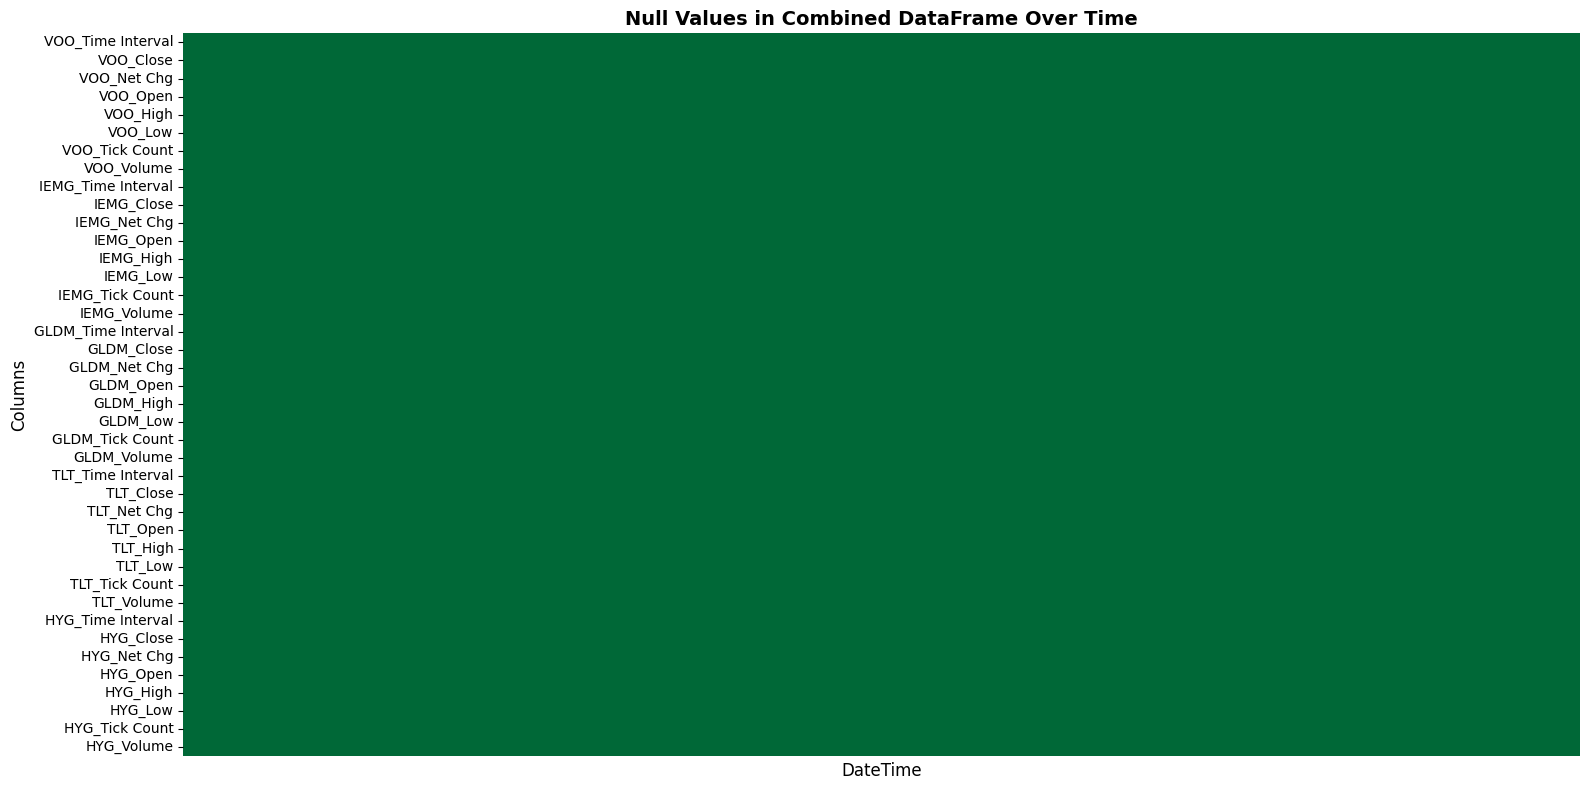

In [25]:
fig, ax = plt.subplots(figsize=(16, 8))

# Create a boolean mask of null values
null_mask = combined_df.isnull()

# Plot null values as a heatmap
# We'll transpose so DateTime is on x-axis and columns on y-axis
sns.heatmap(null_mask.T, cbar=False, cmap='RdYlGn_r', 
            yticklabels=True, xticklabels=False, ax=ax)

ax.set_xlabel('DateTime', fontsize=12)
ax.set_ylabel('Columns', fontsize=12)
ax.set_title('Null Values in Combined DataFrame Over Time', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [32]:
combined_df.to_csv('data.csv')
print(f'Saved combined data to data.csv ({len(combined_df)} rows, {len(combined_df.columns)} columns)')


Saved combined data to data.csv (33367 rows, 40 columns)


## Deprecated

In [33]:
cleaned_data_dir = Path('cleaned_data')
cleaned_data_dir.mkdir(exist_ok=True)

In [34]:
for ticker, df in ticker_data.items():
    output_path = cleaned_data_dir / f'{ticker}.csv'
    df.to_csv(output_path, index=False)
    print(f'Saved {ticker} data to {output_path} ({len(df)} rows)')

Saved VOO data to cleaned_data/VOO.csv (33363 rows)
Saved IEMG data to cleaned_data/IEMG.csv (33351 rows)
Saved GLDM data to cleaned_data/GLDM.csv (33154 rows)
Saved TLT data to cleaned_data/TLT.csv (33363 rows)
Saved HYG data to cleaned_data/HYG.csv (33326 rows)
